In [1]:
#https://www.tensorflow.org/tutorials/text/transformer

In [1]:
import os
import sys
import pretty_midi
import numpy as np
import tensorflow as tf
import math
import random
import matplotlib.pyplot as plt
import time
import argparse
import librosa

In [2]:
workdir = "C:\\Users\\toend\\Documents\\ITU\\Thesis"
pathToSave = os.path.join(workdir, "MIDIdata\\RESULTS")
frequency = 10
DATASET_SIZE = 0

In [3]:
sys.path.append(workdir + '\\Code\\Utils')
from Utils import getAllData
from Utils import getDataSets
from Utils import reshape
from Utils import matchOneToAnyNumberOfMatches
from Utils import piano_roll_to_pretty_midi

LOADING DATA TO PREPARE A PRE-TRAINED MODEL

In [ ]:
Cuts02, Cuts04, Cuts06, Cuts08, Cuts09, Cuts11, Cuts13, Cuts14, Cuts15, Cuts17, Cuts18 = getAllData(frequency) 

In [36]:
print(Cuts02.shape)
print(Cuts04.shape)
print(Cuts06.shape)
print(Cuts08.shape)
print(Cuts09.shape)
print(Cuts11.shape)
print(Cuts13.shape)
print(Cuts14.shape)
print(Cuts15.shape)
print(Cuts17.shape)
print(Cuts18.shape)

(3380, 300, 128)
(5700, 300, 128)
(6496, 300, 128)
(3738, 300, 128)
(5885, 300, 128)
(2333, 300, 128)
(2079, 300, 128)
(6324, 300, 128)
(2183, 300, 128)
(2351, 300, 128)
(5976, 300, 128)


In [37]:
allData = np.concatenate([Cuts02, Cuts04, Cuts06, Cuts08, Cuts09, Cuts11, Cuts13, Cuts14, Cuts15, Cuts17, Cuts18], axis=0)

In [38]:
print(allData.shape)

(46445, 300, 128)


In [99]:
#FOR ALL DATA
encoderRolls = allData
decoderRolls = allData

LOADING DATA TO TRAIN MODEL ON THE MOOD CLASSES

In [227]:
AN, AP, CN, CP = getDataSets(frequency)

In [228]:
#AN
print(AN.shape)
#AP
print(AP.shape)
#CN
print(CN.shape)
#CP
print(CP.shape)

(225, 300, 128)
(280, 300, 128)
(147, 300, 128)
(103, 300, 128)


In [229]:
#REMOVES TEN LAST ELEMENTS FOR VALIDATION
VALIDATION = AP[-5:,:,:]
AP = AP[:-5,:,:]

In [230]:
Z = matchOneToAnyNumberOfMatches(AP, CP, 10)

In [231]:
random.shuffle(Z)

X, Y = zip(*Z)

X = np.array(X)
Y = np.array(Y)

print(X.shape)
print(Y.shape)

(2750, 300, 128)
(2750, 300, 128)


In [232]:
#WITHOUT MATCHING
#X = AP[:225,:,:]
#Y = AN[:225,:,:]

In [233]:
encoderRolls = X
decoderRolls = np.empty((Y.shape[0], Y.shape[1] + 2, Y.shape[2]))

In [234]:
startToken = np.full((128), 0)
endToken = np.full((1, 128), 0)

for i in range(len(Y)):
    paddedRoll = np.insert(Y[i], 0, startToken, axis = 0)
    decoderRolls[i] = np.append(paddedRoll, endToken, axis = 0)

In [235]:
DATASET_SIZE = encoderRolls.shape[0]
print(encoderRolls.shape)
print(decoderRolls.shape)
print(DATASET_SIZE)
print(encoderRolls[1].shape)
print(decoderRolls[1].shape)

(2750, 300, 128)
(2750, 302, 128)
2750
(300, 128)
(302, 128)


In [31]:
num_layers = 2
d_model = 128 #Dimensionality of the input and output of the model
dff = 512 #Dimenstionality of inner-layer in FFN
num_heads = 8
batch_size = 32  #CHANGE DEPENDING ON SIZE OF DATASET
dropout_rate = 0.1
EPOCHS = 1000
seq_length = 300

In [32]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [33]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

In [34]:
#USED TO PAD TOKENS THAT ARE NOT PRIOR TO CURRENT ONE
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [35]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.
  
    Args:
        q: query shape == (..., seq_len_q, depth)
        k: key shape == (..., seq_len_k, depth)
        v: value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable 
            to (..., seq_len_q, seq_len_k). Defaults to None.
    
    Returns:
        output, attention_weights
          """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    #MASK IS NOT NEEDED AND SHOULD BE DISREGARDED
    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [36]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
    
        assert d_model % self.num_heads == 0
    
        self.depth = d_model // self.num_heads
    
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
    
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
    
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
    
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
    
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
        return output, attention_weights

In [37]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [38]:
def final_point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model, activation='sigmoid')  # (batch_size, seq_len, d_model)
  ])

In [39]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
        return out2

In [40]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)
 
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
    
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
        return out3, attn_weights_block1, attn_weights_block2

In [41]:
class Encoder(tf.keras.layers.Layer):
    #def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
    def __init__(self, num_layers, d_model, num_heads, dff, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers
    
        #self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model) #EMBED PIANO ROLLS?
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)
    
    
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]
    
        # adding embedding and position encoding.
        #x = self.embedding(x)  # (batch_size, input_seq_len, d_model)     
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
    
        return x  # (batch_size, input_seq_len, d_model)

In [42]:
class Decoder(tf.keras.layers.Layer):
    #def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
    def __init__(self, num_layers, d_model, num_heads, dff, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers
    
        #self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model) #SAME AS ENCODER EMBEDDING
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}
    
        #x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x = tf.cast(x, tf.float32)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
    
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
      
        attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
        attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [43]:
class Transformer(tf.keras.Model):
    #def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
    def __init__(self, num_layers, d_model, num_heads, dff, pe_input, pe_target, rate=0.1): 
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, pe_input, rate) #removed vocabsize

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, pe_target, rate) #removed vocabsize

        self.final_layer = tf.keras.layers.Dense(d_model, activation='sigmoid') #Replaced vocabsize with d-model and added activation
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
        return final_output, attention_weights

In [44]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=40):
        super(CustomSchedule, self).__init__()
    
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
    
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [45]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

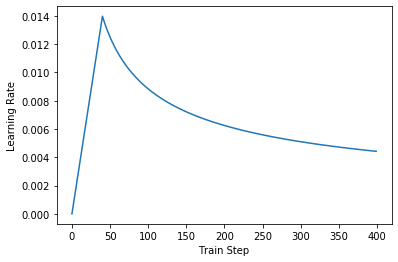

In [46]:
temp_learning_rate_schedule = CustomSchedule(128)

plt.plot(temp_learning_rate_schedule(tf.range(400, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [47]:
#loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
loss_object = tf.keras.losses.BinaryCrossentropy(
    from_logits=False, reduction='none')

In [48]:
def loss_function(real, pred):
    #print(real.shape)
    #print(pred.shape)
    #mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    #mask = tf.cast(mask, dtype=loss_.dtype)
    #loss_ *= mask
  
    return tf.reduce_sum(loss_)#/tf.reduce_sum(mask)

In [49]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
#train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
train_accuracy = tf.keras.metrics.BinaryAccuracy(
    name='train_accuracy', dtype=None, threshold=0.5)

In [50]:
#CHECK PE_INPUT AND PE_TARGET
transformer = Transformer(num_layers, d_model, num_heads, dff, 
                          pe_input=10000, 
                          pe_target=10000,
                          rate=dropout_rate)

In [51]:
def create_masks(tar):
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    return look_ahead_mask

In [236]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [237]:
# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [54]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.float64),
    tf.TensorSpec(shape=(None, None), dtype=tf.float64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:-1, :]
    tar_real = tar[1:, :]
    
    inp = tf.expand_dims(inp, 0)
    tar_inp = tf.expand_dims(tar_inp, 0)
    tar_real = tf.expand_dims(tar_real, 0)
  
    #enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    look_ahead_mask = create_masks(tar_inp)
  
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                    True, 
                                    None, 
                                    look_ahead_mask, 
                                    None)
        
        loss = loss_function(tar_real, predictions)
        
    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [178]:
print(DATASET_SIZE)

2200


In [179]:
print(encoderRolls.shape)
print(decoderRolls.shape)

(2200, 300, 128)
(2200, 302, 128)


In [57]:
for epoch in range(EPOCHS):
    start = time.time()
  
    train_loss.reset_states()
    train_accuracy.reset_states()
  
    # inp -> portuguese, tar -> english
    #for (batch, (inp, tar)) in enumerate(train_dataset):
    #    train_step(inp, tar)
    for i in range(DATASET_SIZE):
        train_step(encoderRolls[i], decoderRolls[i])
        
    
        if i % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
                    epoch + 1, i, train_loss.result(), train_accuracy.result()))
      
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



KeyboardInterrupt: 

Next section will generate piano pieces!

In [180]:
def normalizeData(prediction):
    proto_tensor_output = tf.make_tensor_proto(prediction)
    prediction = tf.make_ndarray(proto_tensor_output)
    
    minElement = prediction.min()
    maxElement = prediction.max()

    normVector = np.full((len(prediction)), minElement)
    
    return (prediction - normVector) / ( maxElement - minElement )

In [181]:
def convertProbabilitiesToActualPianoRoll(decodedPianoRoll):
    pianoRoll = np.where(decodedPianoRoll<0.5, decodedPianoRoll, 1)
    pianoRoll = np.where(pianoRoll>0.5, pianoRoll, 0)
    return pianoRoll

In [182]:
def evaluate(inp_sequence, seed):
    start_token = np.full((d_model), 0)
    end_token = np.full((1, d_model), 0)
  
    #inp_sequence = np.insert(inp_sequence, 0, start_token, axis = 0)
    #inp_sequence = np.append(inp_sequence, end_token, axis = 0)
    encoder_input = tf.expand_dims(inp_sequence, 0)
    print(inp_sequence.shape)
    #encoder_input = inp_sequence
  
    #decoder_input = seed
    decoder_input = np.full((1, d_model), 0)
    
    output = tf.expand_dims(decoder_input, 0)
    print(output.shape)
    #output = decoder_input
    
    for i in range(seq_length):
        look_ahead_mask = create_masks(output)
  
        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, 
                                                     output,
                                                     False,
                                                     None,
                                                     look_ahead_mask,
                                                     None)

        # select the last time-step from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
        
        #Normalizing to squeeze in between 0 and 1
        #predictions = normalizeData(predictions)
        
        #Converting the most probable predictions to values of 1 and most unlikely to 0
        #predictions = convertProbabilitiesToActualPianoRoll(predictions)

        # concatentate the prediction the output which is given to the decoder as its input.
        output = tf.cast(output, tf.float32)
        output = tf.concat([output, predictions], axis=1)

    return tf.squeeze(output, axis=0), attention_weights

In [183]:
def evaluateSongAtIndex(index):
    inp_sequence = VALIDATION[index]
    inp_sequence = tf.cast(inp_sequence, tf.float32)
    #seed = decoderRolls[index,:20,:]
    seed = np.full((10, d_model), 0)
    #for timeStep in seed:
    #    timeStep[56] = 1
    #    timeStep[59] = 1
    #    timeStep[62] = 1
    #    timeStep[66] = 1
    output, _ = evaluate(inp_sequence, seed)
    return output

In [184]:
def convertToPianoRoll(output):
    proto_tensor = tf.make_tensor_proto(output)
    ndarray = tf.make_ndarray(proto_tensor)
    
    #for i in range(len(ndarray)):
    #    print(ndarray[i])
    
    piano_roll = convertProbabilitiesToActualPianoRoll(ndarray)
    piano_roll = piano_roll * 100  
    pianoRoll = reshape(piano_roll)
    return pianoRoll

In [185]:
def saveToMIDI(pianoRoll, index, inputOrOutput, mood2mood):
    pm = piano_roll_to_pretty_midi(pianoRoll, 10, 0)
    pm.write(pathToSave + "\\Transformer" + "_" + inputOrOutput + "_" + mood2mood + "_" + str(index) + ".mid")

In [250]:
index = 4
mood2mood = 'AP2CP'

In [251]:
inputRoll = VALIDATION[index]
inputRoll = convertToPianoRoll(inputRoll)
saveToMIDI(inputRoll, index, 'input', mood2mood)

In [252]:
output = evaluateSongAtIndex(index)
output = convertToPianoRoll(output)
saveToMIDI(output, index, 'output', mood2mood)

(300, 128)
(1, 1, 128)


FOLLOWING SECTION IS SANDBOX

In [51]:
output = evaluateSongAtIndex(index)

(300, 128)
(1, 1, 128)


In [152]:
inp_sequence = encoderRolls[0]
inp_sequence = tf.cast(inp_sequence, tf.float32)

print(inp_sequence[198])
print(inp_sequence.dtype)

tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.], shape=(128,), dtype=float32)
<dtype: 'float32'>


In [153]:
seed = decoderRolls[0,:20,:]
print(seed.shape)

(20, 128)


In [154]:
output, _ = evaluate(inp_sequence, seed)


(300, 128)
(1, 20, 128)


In [52]:
print(output.shape)
for i in range(output.shape[1]):
    print(output[i])

(311, 128)
tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.], shape=(128,), dtype=float32)
tf.Tensor(
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.32862139e-04 1.44958496e-04 5.67734241e-05
 1.10429525e-03 9.60886478e-04 1.00249052e-03 1.32015347e-03
 4.53516841e-03 1.10441446e-02 1.43880546e-02 5.08546829e-02
 2.31728852e-02 3.40253413e-02 2.13336945e-02 3.38339806e-

In [156]:
# remove values from `X` in interval (lo, hi)
#mask = tf.math.less(output, 0.5)
#test = tf.boolean_mask(output, mask)

In [157]:
proto_tensor_output = tf.make_tensor_proto(output)
ndarray_output = tf.make_ndarray(proto_tensor_output)

In [158]:
piano_roll_output = piano_roll_output * 100

In [159]:
piano_roll_output = convertProbabilitiesToActualPianoRoll(ndarray_output)

In [160]:
piano_roll_output = piano_roll_output * 100

In [161]:
print(piano_roll_output.shape)
print(piano_roll_output[101])

(320, 128)
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0. 100.   0. 100.   0.   0. 100.   0.   0.   0.   0.   0. 100.   0.
   0.   0.   0.   0. 100.   0. 100.   0.   0.   0.   0. 100.   0.   0.
 100.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.]


In [162]:
#Reshaping to become an actual pianoRoll
pianoRoll_output = reshape(piano_roll_output)
print(pianoRoll_output.shape)

(128, 320)


In [163]:
#saving to midi
pm_output = piano_roll_to_pretty_midi(pianoRoll_output, 10, 0)
pm_output.write(pathToSave + "\\Transformer" + "_output" + str(1) + ".mid")

In [159]:
proto_tensor_input = tf.make_tensor_proto(decoderRolls[1])
ndarray_input = tf.make_ndarray(proto_tensor_input)

In [160]:
piano_roll_input = convertProbabilitiesToActualPianoRoll(ndarray_input)

In [161]:
piano_roll_input = piano_roll_input * 100

In [162]:
#Reshaping to become an actual pianoRoll
pianoRoll_input = reshape(piano_roll_input)
print(pianoRoll_input.shape)

(128, 302)


In [163]:
#saving to midi
pm_input = piano_roll_to_pretty_midi(pianoRoll_input, 10, 0)
pm_input.write(pathToSave + "\\Transformer" + "_input" + str(1) + ".mid")

In [103]:
def plot_attention_weights(attention, sequence, result, layer):
    fig = plt.figure(figsize=(16, 8))
  
    #sentence = tokenizer_pt.encode(sentence)
  
    attention = tf.squeeze(attention[layer], axis=0)
  
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)
    
        # plot the attention weights
        ax.matshow(attention[head][:-1, :], cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(sequence)+2))
        ax.set_yticks(range(len(result)))

        ax.set_ylim(len(result)-1.5, -0.5)

        ax.set_xticklabels(
            ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
            fontdict=fontdict, rotation=90)

        ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                            if i < tokenizer_en.vocab_size], 
                           fontdict=fontdict)

        ax.set_xlabel('Head {}'.format(head+1))
  
    plt.tight_layout()
    plt.show()

In [72]:
look_ahead_mask = create_look_ahead_mask(302)

In [73]:
print(look_ahead_mask)

tf.Tensor(
[[0. 1. 1. ... 1. 1. 1.]
 [0. 0. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(302, 302), dtype=float32)
